In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.api as smt
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
# from statsmodels.tsa.vector_ar.vecm import select_order, select_coint_rank
# from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import combinations

from nonlin_coint.data_process import *
from nonlin_coint.VECM import *
import os

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

## Data preparation

In [2]:
tickers = ['MGC', 'VONE', 'VOO', 'RSP', 'SPY', 'VV', 'IWV', 'FEX', 'IVV', 'ITOT', 'IYY', 'IWB', 'VTI', 'SCHB']

In [3]:
try:
    data = pd.read_csv('./sp500_etf.csv', index_col = 0)
    data.index = pd.to_datetime(data.index)
except:
    data = price_data()
    data.to_csv('./sp500_etf.csv')
    np.log(data).to_csv("./sp500_etf_log.csv")

In [4]:
years = data.index.year.unique()

## Cointegrated Pairs

### Example

In [10]:
price_in, price_out, ret_in, ret_out = yearly_sample(2015, data)
pair = ['IVV','SPY']

train = ret_in[pair]
test = ret_out[pair]

train_log = np.log(price_in[pair])
train_price = price_in[pair]
test = price_out[pair]

1) Price series should be cointegrated - to form a stationary spread

In [11]:
jres = coint_johansen(train_price, det_order=0, k_ar_diff=4)
jres.trace_stat_crit_vals,jres.trace_stat

(array([[13.4294, 15.4943, 19.9349],
        [ 2.7055,  3.8415,  6.6349]]),
 array([68.9579743 ,  1.27630391]))

2) Return series better be cointegrated - if not, the spread could be volatile and non-stationary in out-sample

In [12]:
jres2 = coint_johansen(train, det_order=0, k_ar_diff=4)
jres2.trace_stat_crit_vals, jres2.trace_stat

(array([[13.4294, 15.4943, 19.9349],
        [ 2.7055,  3.8415,  6.6349]]),
 array([77.68137227,  2.0145749 ]))

Sprad is stationary, but not strictly random walk.

<Axes: xlabel='date'>

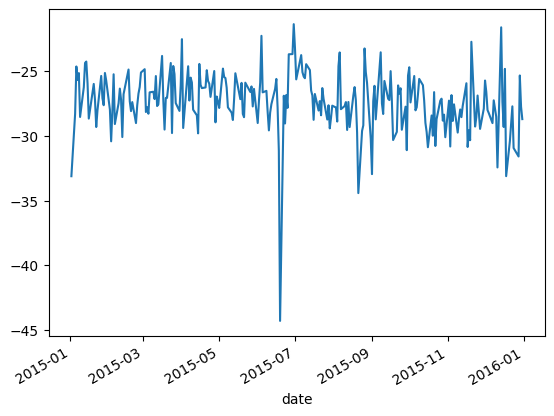

In [13]:
spread = jres.evec[:,0] @ test.T

i0 = spread.diff()
spread.plot()

In [14]:
ts.adfuller(spread, regression = 'n'), ts.adfuller(spread, regression = 'c')

((0.01297451139785009,
  0.6885791245108992,
  6,
  245,
  {'1%': -2.5749261391087046,
   '5%': -1.9421502633766543,
   '10%': -1.6157794081377657},
  1075.4926131689504),
 (-13.036109955577079,
  2.291495551479312e-24,
  0,
  251,
  {'1%': -3.4566744514553016,
   '5%': -2.8731248767783426,
   '10%': -2.5729436702592023},
  1054.3171053995943))

In [46]:
def jo_yearly(year, price_in, price_out, ret_in, ret_out):
    result = []
    for pair in combinations(tickers, 2):
        temp = get_johansen_result(pair, price_in, price_out, ret_in, ret_out)
        temp['year'] = year
        result.append(temp)
    johansen_result = pd.DataFrame(result)
    return johansen_result


In [5]:
try:
    vecm_res = pd.read_csv("./result/vecm_res.csv")
except:
    vecm_res = []
    for y in tqdm(range(2013, 2023)):
        vecm_res.append(jo_yearly(y, *yearly_sample(y, data)))
    vecm_res = pd.concat(vecm_res)
    vecm_res.to_csv('./result/vecm_res.csv', index = False)

In [6]:
vecm_res.sort_values('in_adf_n')

pair  stat1_ret  stat2_ret  stat1_price  stat2_price  \
295  ('VONE', 'IWB')       0.01        1.0         0.01          1.0   
113  ('VONE', 'IWB')       0.01        1.0         0.01          1.0   
849   ('VOO', 'IVV')       0.01        1.0         0.01          1.0   
526  ('FEX', 'ITOT')       0.05        1.0         0.05          1.0   
529   ('FEX', 'VTI')       0.05        1.0         0.05          1.0   
..               ...        ...        ...          ...          ...   
618   ('FEX', 'IYY')       1.00        1.0         1.00          1.0   
897   ('IVV', 'IWB')       1.00        1.0         1.00          1.0   
851   ('VOO', 'IYY')       1.00        1.0         1.00          1.0   
870   ('SPY', 'IYY')       1.00        1.0         1.00          1.0   
896   ('IVV', 'IYY')       1.00        1.0         1.00          1.0   

         in_adf_n      in_adf_c     out_adf_n     out_adf_c  order  year  
295  1.838047e-15  1.942716e-15  6.040855e-01  1.863447e-01      0  2016  
113  1.870190e-07  3.464462e-24  4.804201e-02  8.766911e-16      0  2014  
849  1.001176e-06  1.587415e-05  3.599359e-09  2.138801e-08      9  2022  
526  4.137804e-04  6.695948e-03  9.626773e-01  9.715532e-01      1  2018  
529  9.871794e-04  9.691406e-03  9.826553e-01  9.820555e-01      1  2018  
..            ...           ...           ...           ...    ...   ...  
618  9.687449e-01  8.856043e-01  9.999790e-01  9.485716e-01      1  2019  
897  9.693022e-01  9.640791e-01  2.787445e-01  1.326728e-01      9  2022  
851  9.794591e-01  9.808446e-01  3.357392e-01  1.134209e-01      9  2022  
870  9.800807e-01  9.807688e-01  4.052350e-01  6.788360e-02      9  2022  
896  9.812624e-01  9.826717e-01  3.428865e-01  1.160982e-01      9  2022  

[910 rows x 11 columns]

###  SPY, IVV. Stationary spread

In [59]:
vecm_res[vecm_res.pair == "('SPY', 'IVV')"]

pair  stat1_ret  stat2_ret  stat1_price  stat2_price  in_adf_n  \
49   ('SPY', 'IVV')       0.01        1.0         0.01          1.0  0.558151   
140  ('SPY', 'IVV')       0.01        1.0         0.01          1.0  0.643636   
231  ('SPY', 'IVV')       0.01        1.0         0.01          1.0  0.708285   
322  ('SPY', 'IVV')       0.01        1.0         0.01          1.0  0.681026   
413  ('SPY', 'IVV')       0.01        1.0         0.01          1.0  0.643667   
504  ('SPY', 'IVV')       0.01        1.0         0.01          1.0  0.577802   
595  ('SPY', 'IVV')       0.01        0.1         0.01          0.1  0.389929   
686  ('SPY', 'IVV')       0.01        1.0         0.01          1.0  0.529709   
777  ('SPY', 'IVV')       0.05        0.1         0.05          1.0  0.475573   
868  ('SPY', 'IVV')       0.01        1.0         0.01          1.0  0.732071   

         in_adf_c  out_adf_n     out_adf_c  order  year  
49   0.000000e+00   0.376675  5.299119e-14      5  2013  
140  0.000000e+00   0.539650  1.135875e-02      0  2014  
231  3.981408e-20   0.688944  2.302599e-24      0  2015  
322  5.925480e-08   0.452876  5.085491e-04      0  2016  
413  1.032217e-04   0.797982  1.339185e-03      5  2017  
504  1.109065e-08   0.386845  1.412249e-01      1  2018  
595  1.093038e-01   0.612623  1.326108e-05     10  2019  
686  1.180283e-03   0.813894  4.961854e-01     10  2020  
777  2.381366e-01   0.357661  1.848266e-01     10  2021  
868  2.300323e-02   0.948941  9.796590e-01     10  2022

['SPY', 'IVV']
[ 1.         -0.98686088]
(0.059064725574651464, 0.5923652670944106)


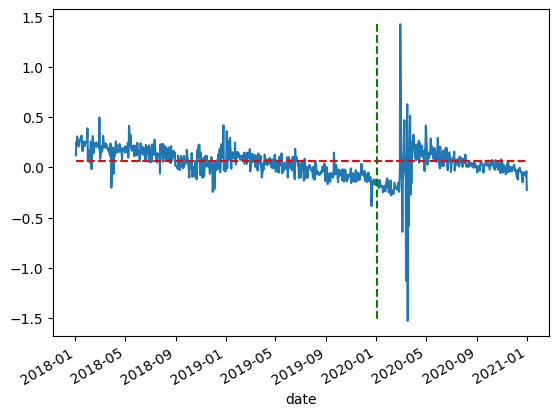

[1, -0.9820615216170017]
(0.40322641910715673, 0.0007142003952424892)


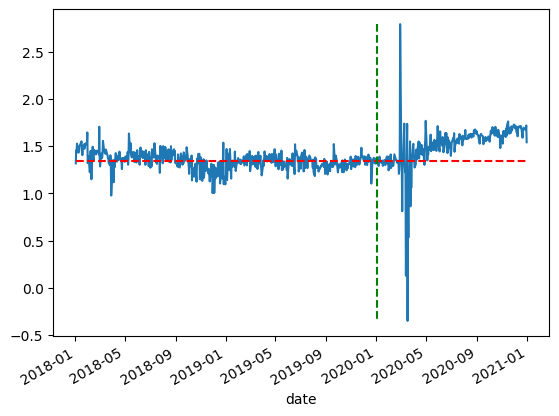

date
2018-01-02    1.316961
2018-01-03    1.454941
2018-01-04    1.432291
2018-01-05    1.526297
2018-01-08    1.432630
                ...   
2020-12-24    1.693789
2020-12-28    1.671031
2020-12-29    1.674974
2020-12-30    1.717736
2020-12-31    1.540287
Length: 756, dtype: float64

In [73]:
# pair_info = working.iloc[-1]
pair_info = vecm_res.iloc[686]
pair = list(eval(pair_info['pair']))
print(pair)

price_in, price_out, ret_in, ret_out = yearly_sample(pair_info['year'], data)
train, test = price_in[pair], price_out[pair]

common_trend_vecm(train, test)
common_trend_ols(train, test)

### Inaccurate VECM

In [67]:
vecm_res[vecm_res.pair == "('IWV', 'FEX')"]

pair  stat1_ret  stat2_ret  stat1_price  stat2_price  in_adf_n  \
63   ('IWV', 'FEX')       1.00        1.0         1.00          1.0  0.739329   
154  ('IWV', 'FEX')       1.00        1.0         1.00          1.0  0.922104   
245  ('IWV', 'FEX')       1.00        1.0         1.00          1.0  0.316759   
336  ('IWV', 'FEX')       1.00        1.0         1.00          1.0  0.836340   
427  ('IWV', 'FEX')       1.00        1.0         1.00          1.0  0.769007   
518  ('IWV', 'FEX')       0.05        1.0         0.05          1.0  0.031592   
609  ('IWV', 'FEX')       0.05        1.0         0.10          1.0  0.356248   
700  ('IWV', 'FEX')       1.00        1.0         1.00          1.0  0.820484   
791  ('IWV', 'FEX')       1.00        1.0         1.00          1.0  0.740706   
882  ('IWV', 'FEX')       0.10        1.0         1.00          1.0  0.531461   

     in_adf_c  out_adf_n  out_adf_c  order  year  
63   0.145283   0.992034   0.803980      5  2013  
154  0.076654   0.809720   0.741507      1  2014  
245  0.126673   0.962824   0.960210      1  2015  
336  0.243585   0.918936   0.822633      1  2016  
427  0.444382   0.996296   0.899001      1  2017  
518  0.008541   0.970476   0.976712      1  2018  
609  0.996304   0.970909   0.961970      0  2019  
700  0.321545   0.730592   0.560168      0  2020  
791  0.126857   0.958853   0.260080      9  2021  
882  0.017394   0.209218   0.512285      9  2022

['IWV', 'FEX']
[ 1.         -2.70737301]
(0.9209713465126862, 0.9957836435403846)


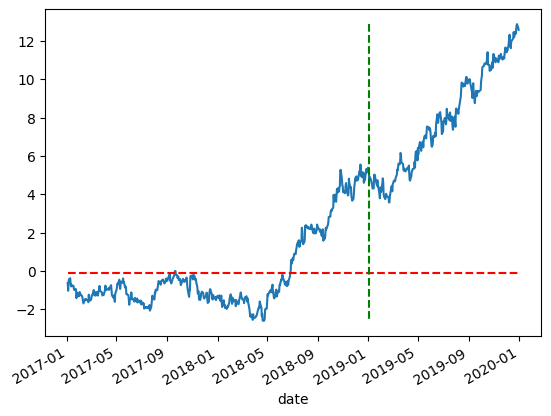

[1, -2.8484451433233655]
(0.31433361845584995, 0.9886428204451774)


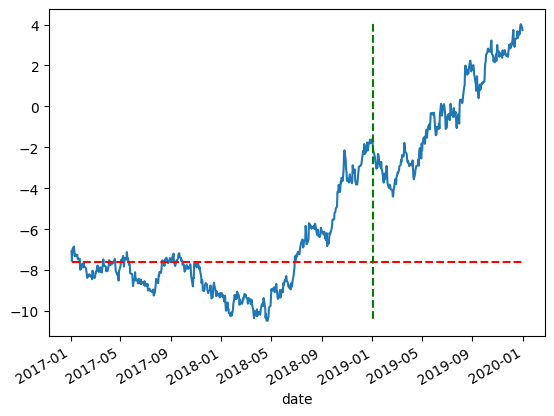

date
2017-01-03   -7.069926
2017-01-04   -7.543682
2017-01-05   -7.032208
2017-01-06   -6.926754
2017-01-09   -6.839965
                ...   
2019-12-24    3.522943
2019-12-26    3.942506
2019-12-27    4.018093
2019-12-30    3.859391
2019-12-31    3.727726
Length: 754, dtype: float64

In [75]:
# pair_info = working.iloc[-1]
pair_info = vecm_res.iloc[609]
pair = list(eval(pair_info['pair']))
print(pair)

price_in, price_out, ret_in, ret_out = yearly_sample(pair_info['year'], data)
train, test = price_in[pair], price_out[pair]

common_trend_vecm(train, test)
common_trend_ols(train, test)

In [94]:
vecm_res[vecm_res.pair == "('MGC', 'RSP')"]

pair  stat1_ret  stat2_ret  stat1_price  stat2_price  in_adf_n  \
2    ('MGC', 'RSP')       1.00        1.0         1.00          1.0  0.783739   
93   ('MGC', 'RSP')       1.00        1.0         1.00          1.0  0.837559   
184  ('MGC', 'RSP')       1.00        1.0         1.00          1.0  0.529179   
275  ('MGC', 'RSP')       1.00        0.1         1.00          0.1  0.883744   
366  ('MGC', 'RSP')       1.00        1.0         1.00          0.1  0.853222   
457  ('MGC', 'RSP')       1.00        1.0         1.00          1.0  0.787089   
548  ('MGC', 'RSP')       0.01        1.0         0.01          1.0  0.329697   
639  ('MGC', 'RSP')       1.00        1.0         0.05          0.1  0.739482   
730  ('MGC', 'RSP')       1.00        1.0         1.00          1.0  0.776561   
821  ('MGC', 'RSP')       1.00        1.0         1.00          1.0  0.781492   

     in_adf_c  out_adf_n  out_adf_c  order  year  
2    0.340711   0.990553   0.694208      5  2013  
93   0.504786   0.765658   0.633117      1  2014  
184  0.084891   0.931746   0.917952      0  2015  
275  0.927963   0.399578   0.098431      0  2016  
366  0.512128   0.999984   0.963543      0  2017  
457  0.138159   0.132953   0.884261      1  2018  
548  0.826266   0.834210   0.004773      0  2019  
639  0.115454   0.554325   0.339874      0  2020  
730  0.181453   0.967479   0.117076      9  2021  
821  0.152008   0.017465   0.433045      9  2022

['MGC', 'RSP']
[ 0.94320418 -1.09963237]
(0.3296974555712907, 0.8262664794616701)


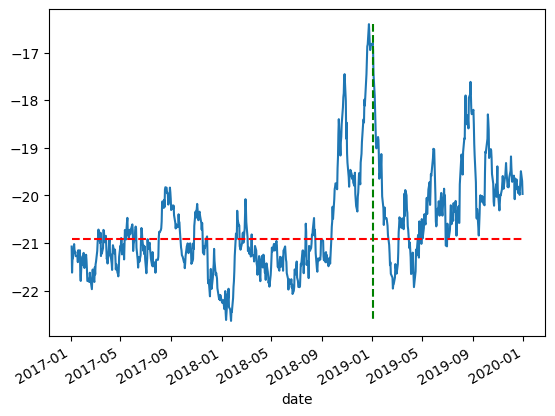

[1, -1.151122765362741]
(0.31282692428523173, 0.8394052975004012)


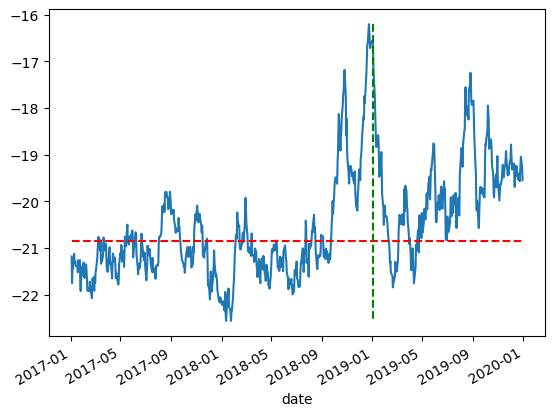

date
2017-01-03   -21.179534
2017-01-04   -21.748003
2017-01-05   -21.461391
2017-01-06   -21.439156
2017-01-09   -21.120276
                ...    
2019-12-24   -19.567487
2019-12-26   -19.235122
2019-12-27   -19.039936
2019-12-30   -19.265218
2019-12-31   -19.545204
Length: 754, dtype: float64

In [96]:
# pair_info = working.iloc[-1]
pair_info = vecm_res.iloc[548]
pair = list(eval(pair_info['pair']))
print(pair)

price_in, price_out, ret_in, ret_out = yearly_sample(pair_info['year'], data)
train, test = price_in[pair], price_out[pair]

common_trend_vecm(train, test)
common_trend_ols(train, test)

In [99]:
def calc_agg(df, threshold = 0.01):
    stat = [
        len(df[df.stat1_price <= threshold]),
        len(df[(df.stat1_price <= threshold) & (df.in_adf_n <= 0.1)]),
        len(df[(df.stat1_price <= threshold) & (df.in_adf_n <= 0.5)]),
        len(df[(df.stat1_price <= threshold) & (df.in_adf_n <= 0.5) & (df.out_adf_n <= 0.5)]),
    ]
    index = ['total', 'in_adf_n_10', 'in_adf_n_5', 'in_adf_n_10_out_adf_n_10']
    return pd.Series(stat, index = index)

vecm_res.groupby('year').apply(calc_agg)

total  in_adf_n_10  in_adf_n_5  in_adf_n_10_out_adf_n_10
year                                                          
2013     11            2           4                         2
2014     12            1           5                         4
2015      6            0           2                         1
2016      5            1           1                         0
2017      3            0           0                         0
2018      9            0           2                         0
2019     21            0          19                         3
2020      5            0           0                         0
2021      4            0           1                         0
2022      4            1           2                         1

In [87]:
working = vecm_res[(vecm_res.stat1_ret== 0.01) & (vecm_res.stat1_price <= 0.01)]

All the possible pairs from VECM

['VONE', 'VV'] 0.0083672657087003 0.6565296987011141
[ 12.47009014 -12.47025625]


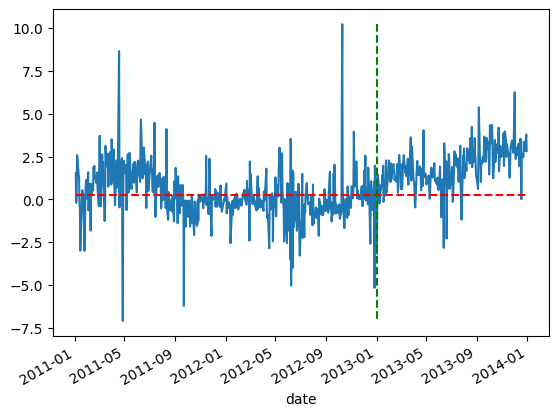

['VONE', 'ITOT'] 0.513639265508465 0.3466263963215225
[ 14.77032969 -29.56172831]


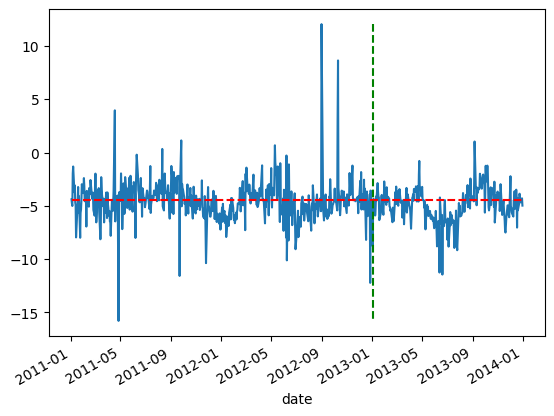

['VONE', 'IWB'] 0.5187560753584352 0.6486036750790536
[ 15.38929839 -12.65779381]


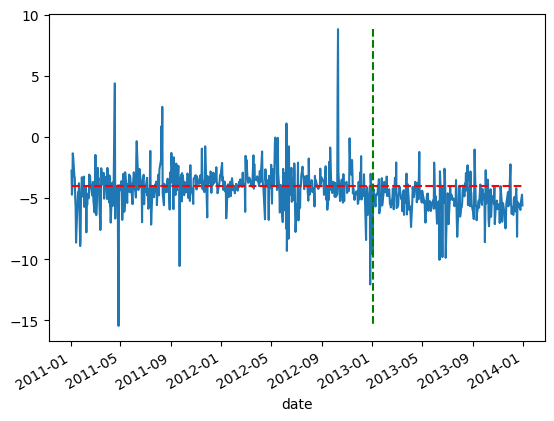

['VONE', 'SCHB'] 0.3451046328428662 0.7902631540258055
[ 10.62999671 -40.73726031]


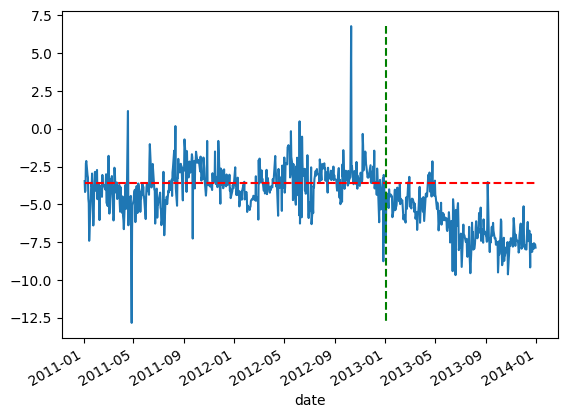

['VOO', 'IVV'] 0.5719416374352281 0.7094363388005246
[ 36.26105226 -33.25369238]


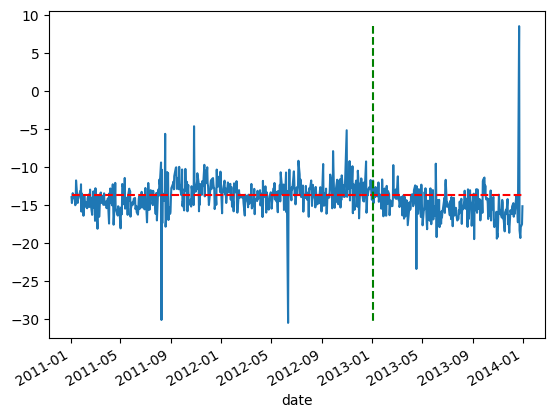

['SPY', 'IVV'] 0.5581506823646809 0.376675120452275
[ 39.44482231 -39.0241786 ]


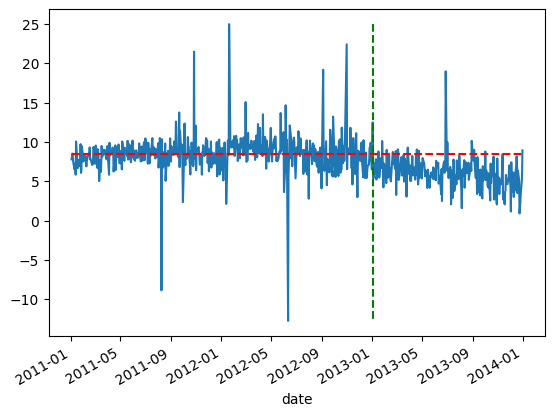

['ITOT', 'IWB'] 0.0367789184010292 0.0183056706058033
[ 36.23196161 -14.89258947]


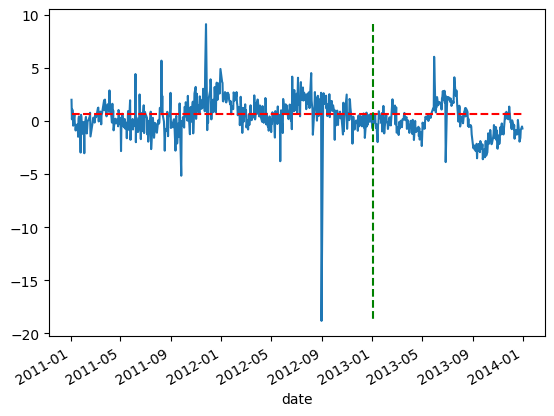

['IYY', 'VTI'] 0.6335618032998624 0.1833601642704959
[ 47.25866932 -23.14447612]


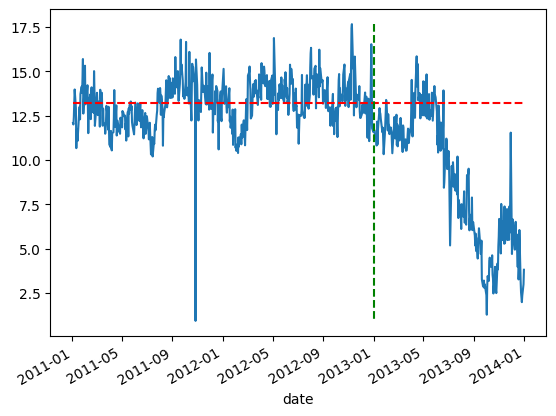

['IYY', 'SCHB'] 0.4507911462979866 0.19166812207401
[  50.77570087 -106.61539622]


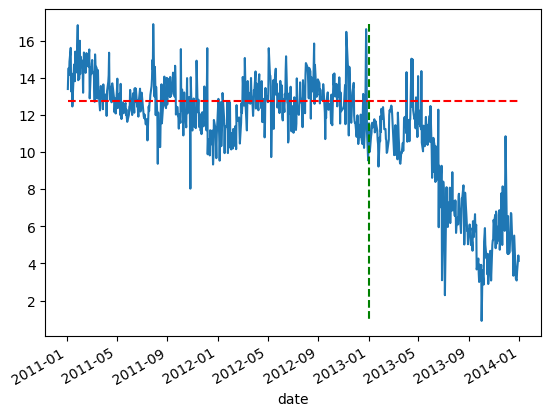

['VONE', 'VV'] 0.6937861936459092 0.9804300781775542
[ 13.40185106 -13.58354082]


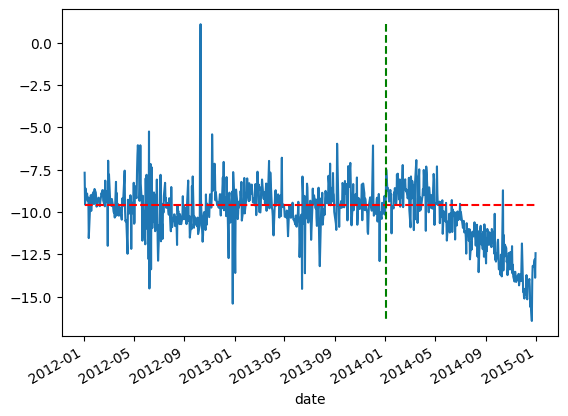

['VONE', 'IWV'] 0.5139195059708358 0.8734394303056867
[11.00883695 -8.2921571 ]


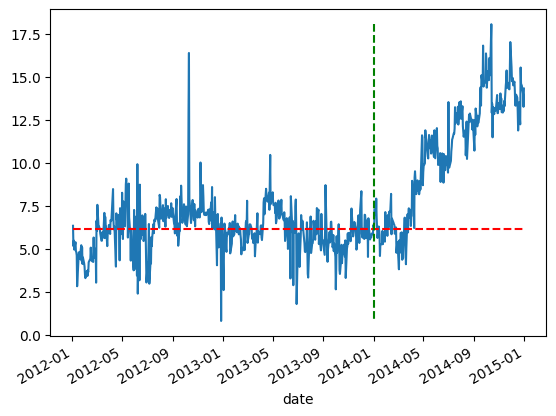

['VONE', 'ITOT'] 0.2606267554453497 0.006516432863085
[ 12.38554797 -24.77027691]


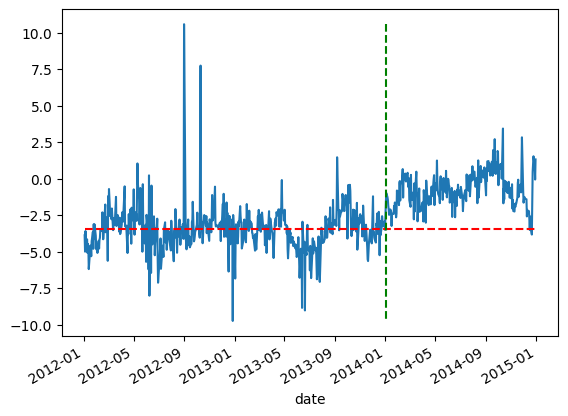

['VONE', 'IYY'] 0.3851931771877542 0.1654696148260652
[ 11.84885337 -21.45766961]


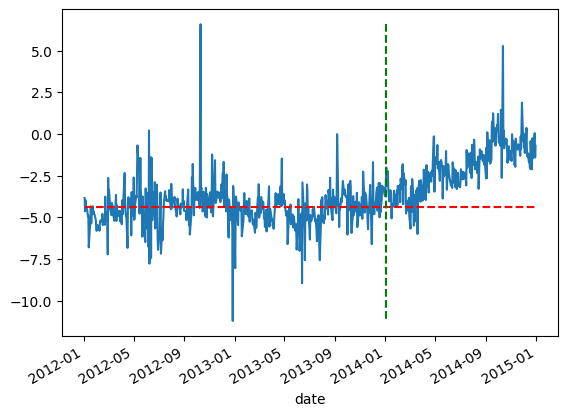

['VONE', 'IWB'] 1.870189569518403e-07 0.0480420079992759
[ 13.68765479 -11.19461996]


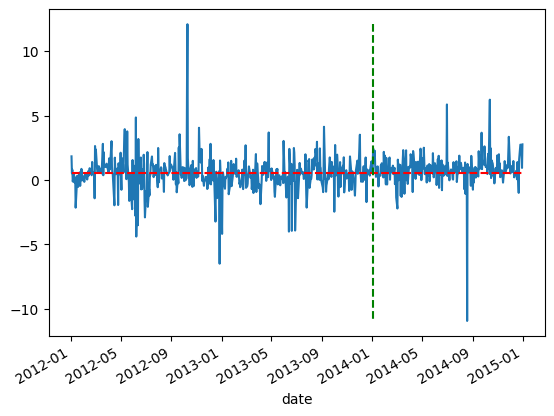

['VONE', 'VTI'] 0.5963545322562095 0.8697858088660204
[10.83455459 -9.46370618]


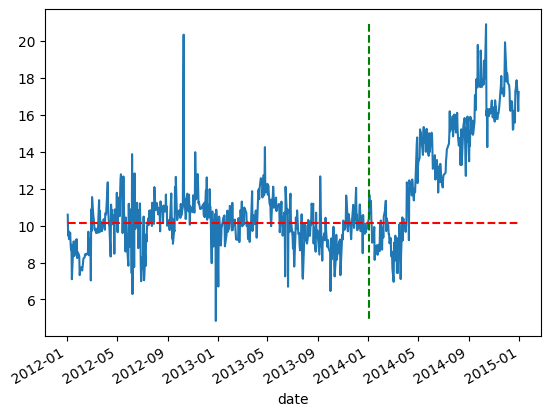

['VONE', 'SCHB'] 0.6149589617687934 0.6036820785748174
[ 11.93591958 -44.79348083]


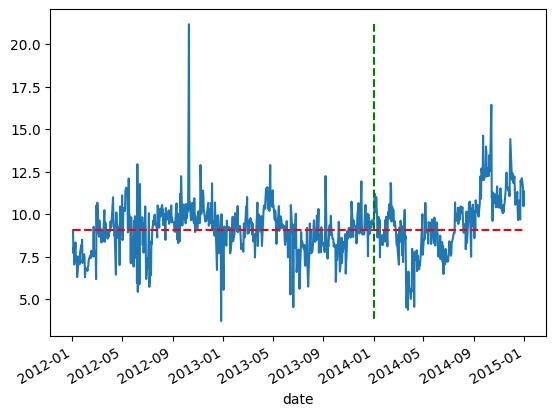

['VOO', 'SPY'] 0.5606276011200755 0.4537704792358109
[ 16.81736294 -15.60328875]


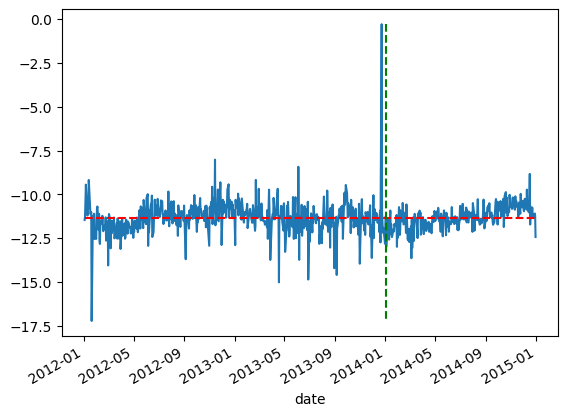

['VOO', 'IVV'] 0.4783589297665965 0.5684802139565355
[ 17.26496165 -15.80699479]


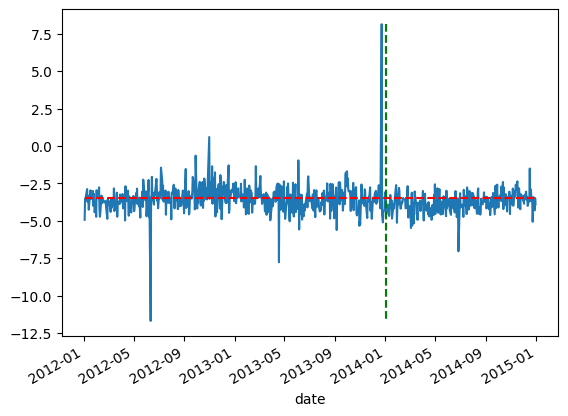

['SPY', 'IVV'] 0.6436363734647986 0.5396497823411011
[ 17.04247625 -16.81743821]


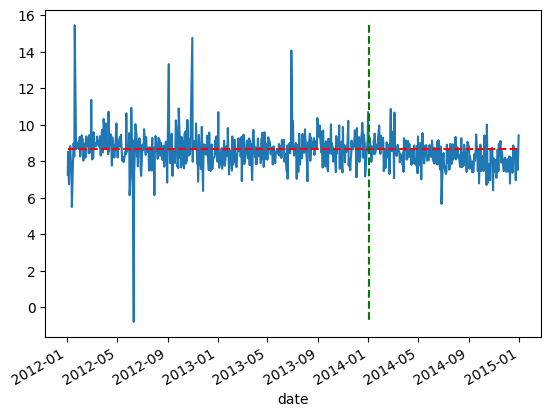

['VV', 'ITOT'] 0.6646764424475052 0.9142904352212118
[ 16.40024921 -32.34402408]


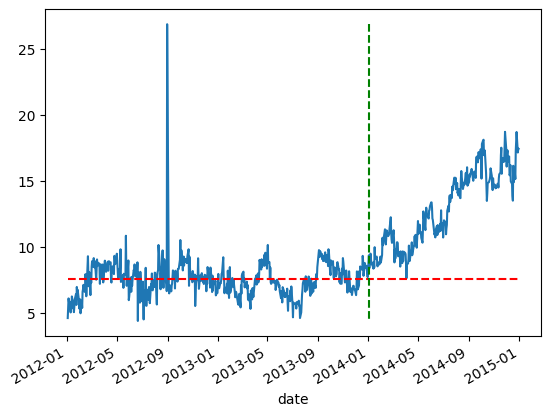

['ITOT', 'IYY'] 0.2903110480144624 0.3022987339269075
[ 37.58622999 -34.07012285]


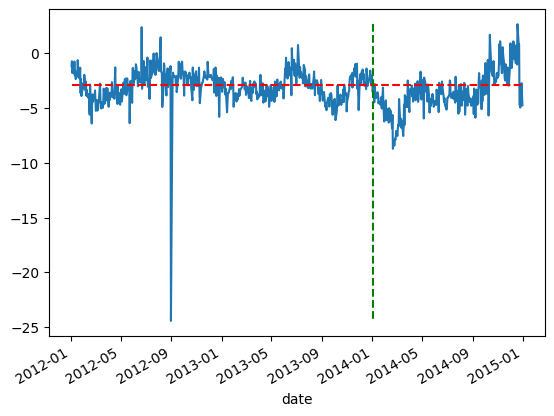

['VONE', 'IWB'] 0.1655884805203806 0.2740419999838183
[12.07195007 -9.89512393]


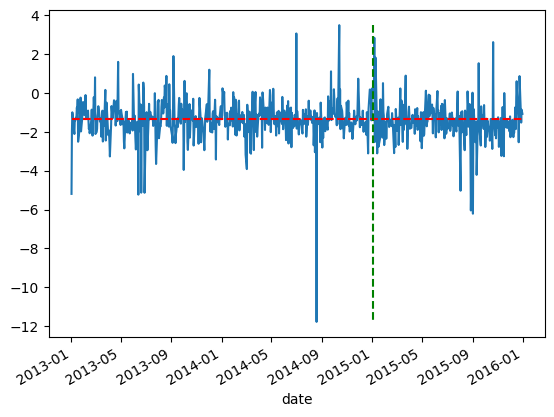

['VOO', 'SPY'] 0.7159282416938767 0.72454246648725
[ 18.40014395 -17.07770543]


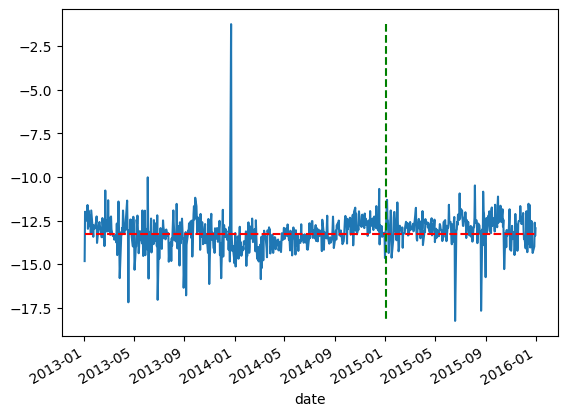

['VOO', 'IVV'] 0.5207562914098772 0.5552702982969777
[ 19.39687688 -17.75304173]


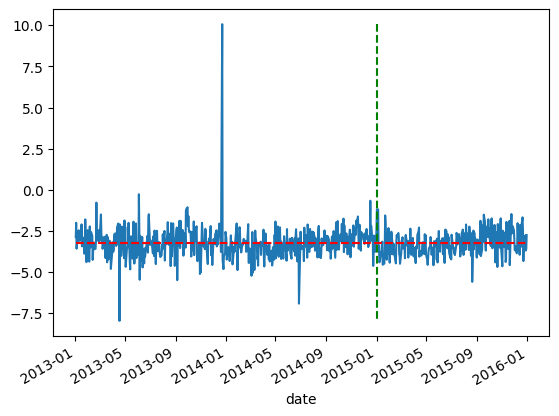

['RSP', 'SCHB'] 0.3805175683551717 0.91795839108322
[  5.68819854 -18.91052185]


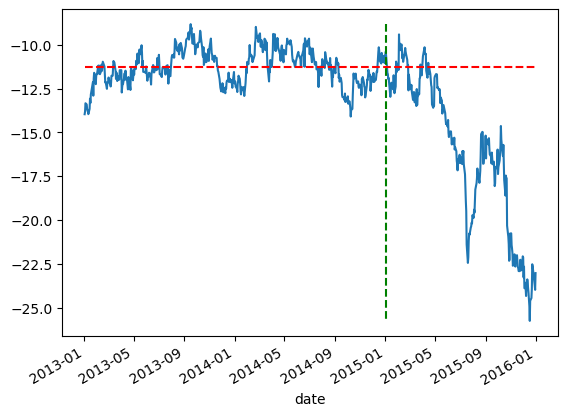

['SPY', 'IVV'] 0.7082854829131826 0.6889436820491054
[ 23.54276068 -23.21621492]


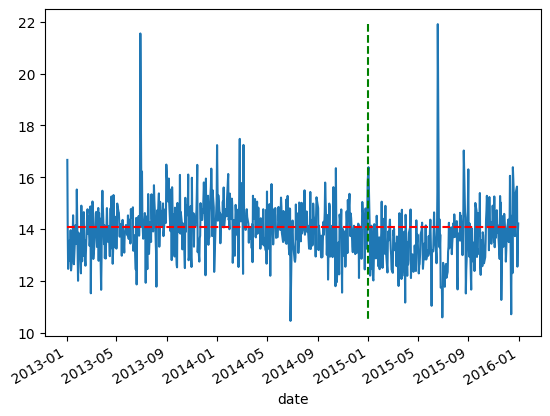

['IWV', 'VTI'] 0.7358802550296235 0.6844542370004114
[ 25.50228675 -29.39654448]


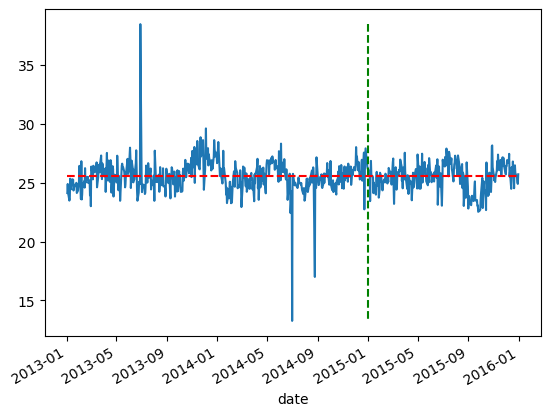

['VONE', 'IWB'] 1.8380466495345675e-15 0.6040854693090796
[11.72908098 -9.59912092]


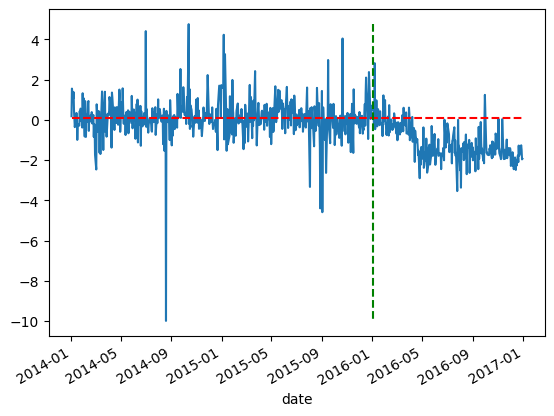

['VOO', 'SPY'] 0.6460721338452093 0.2836281673279586
[ 24.20911376 -22.50558215]


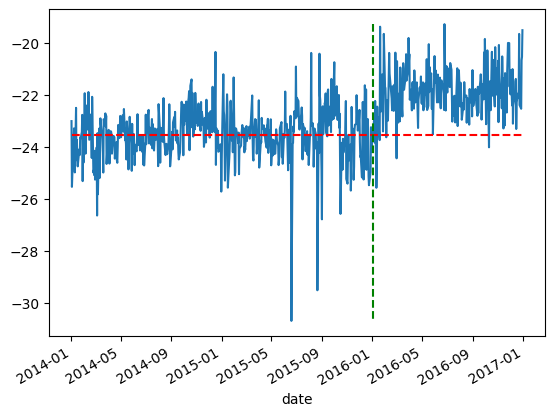

['VOO', 'IVV'] 0.5433702189148386 0.4558715643147231
[ 26.80480678 -24.54413012]


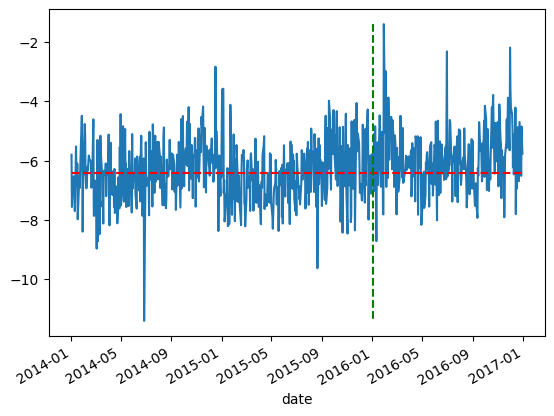

['SPY', 'IVV'] 0.681026157400785 0.4528756949479244
[ 22.90515681 -22.56099211]


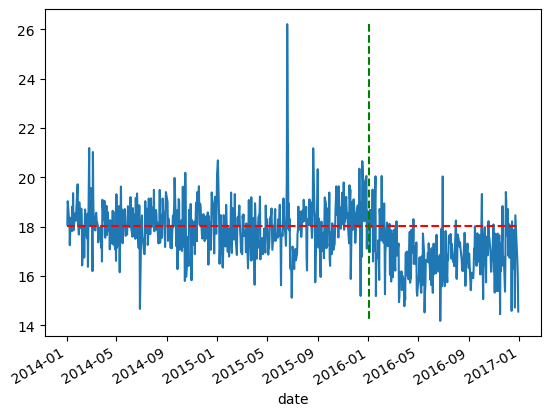

['IWV', 'VTI'] 0.5879976650646915 0.6519706935004284
[ 30.45605292 -35.16451295]


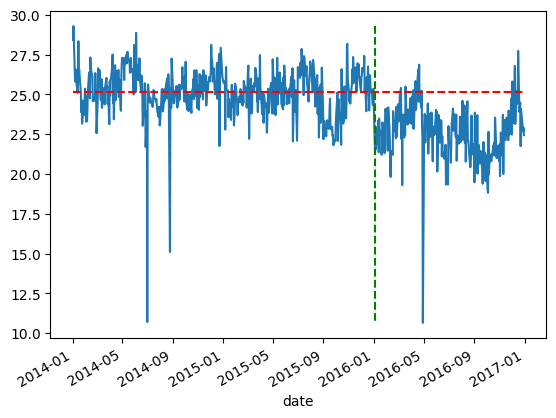

['VOO', 'IVV'] 0.5312527002975723 0.7653692876293582
[ 47.90391164 -43.88077792]


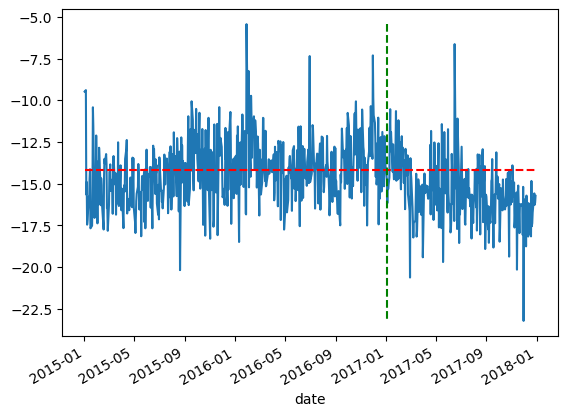

['SPY', 'IVV'] 0.6436671722492345 0.797981771419637
[ 30.46858215 -29.95193821]


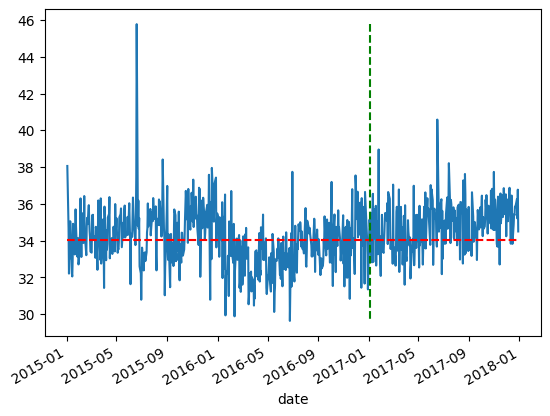

['VTI', 'SCHB'] 0.6799843935006239 0.8832369272499012
[  34.81721209 -149.59137442]


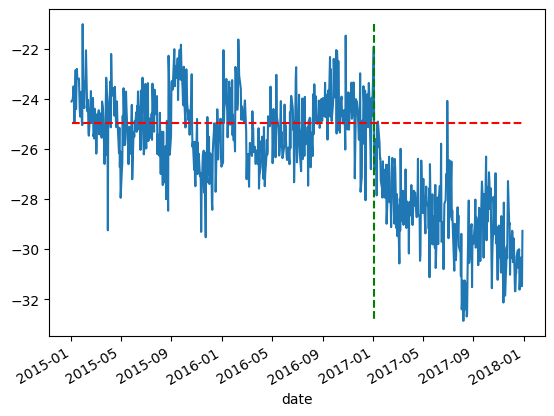

['VOO', 'SPY'] 0.5337374573549731 0.5170433956722498
[ 43.23410005 -40.18904137]


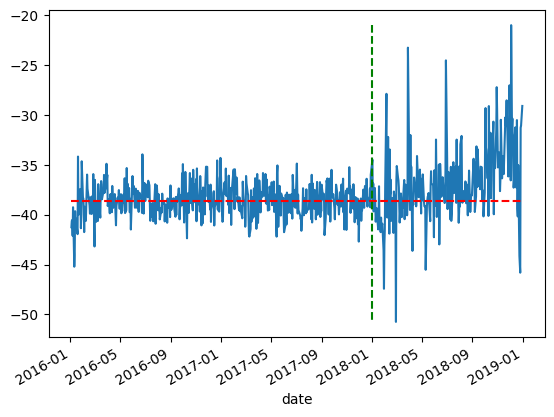

['VOO', 'VV'] 0.8919617481046329 0.5142969073592871
[  9.72373766 -19.23330471]


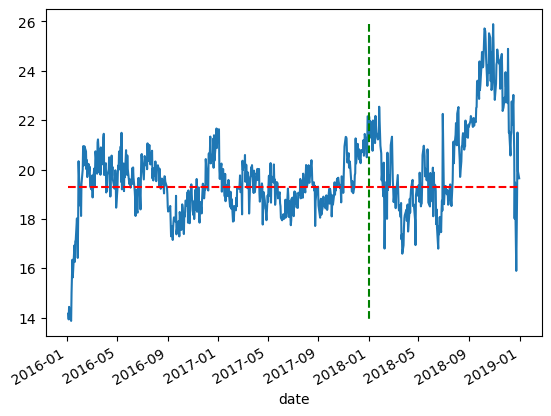

['VOO', 'IVV'] 0.3307928069398514 0.7423610078118209
[ 40.95468133 -37.47294889]


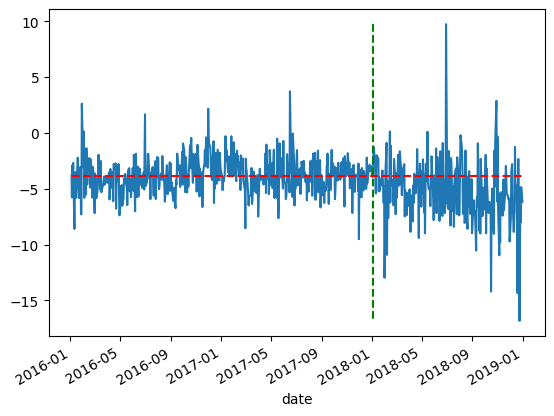

['SPY', 'VV'] 0.8863479177541671 0.4756404823783243
[  9.08778608 -19.33616785]


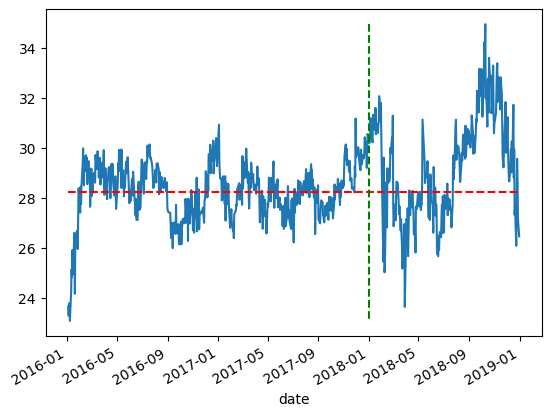

['SPY', 'IVV'] 0.5778019281569609 0.3868453487361191
[ 32.84016032 -32.32469448]


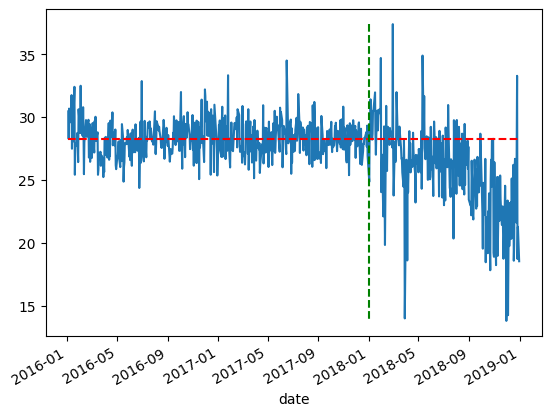

['VV', 'IVV'] 0.8843801331605495 0.582797851623068
[18.13017953 -8.38796648]


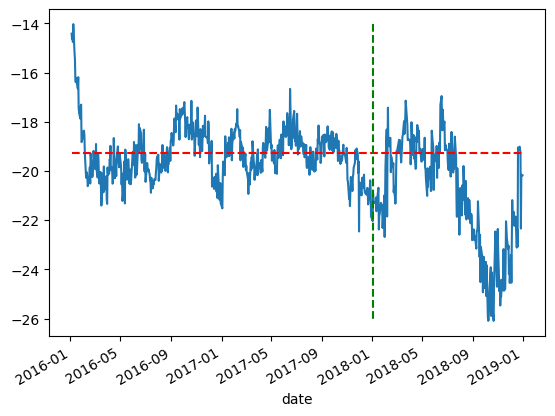

['IWV', 'VTI'] 0.6565807753085112 0.1409857000063627
[ 28.6962356 -33.0599186]


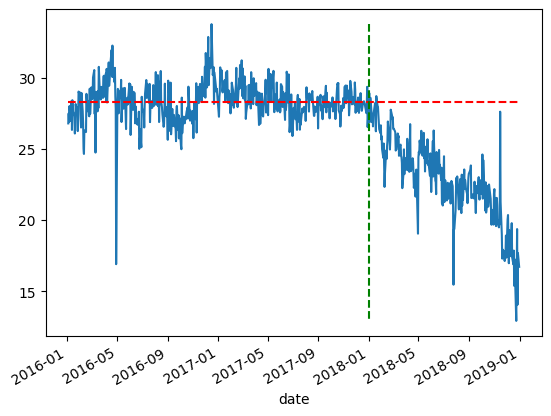

['ITOT', 'VTI'] 0.5070398123199709 0.1252565926998065
[ 81.59715677 -36.268463  ]


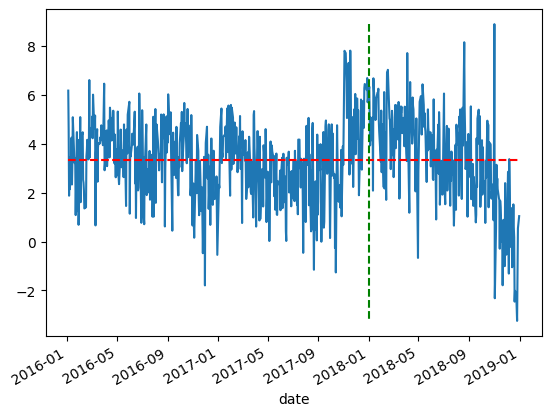

['MGC', 'RSP'] 0.3296974555712907 0.834210131888492
[ 0.94320418 -1.09963237]


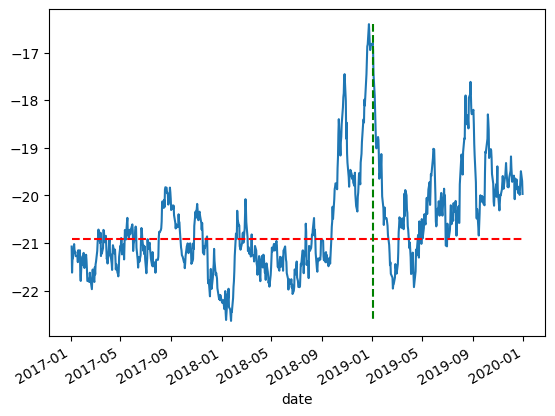

['MGC', 'IWV'] 0.1781259196797438 0.6259295171750845
[ 1.73332828 -1.00478172]


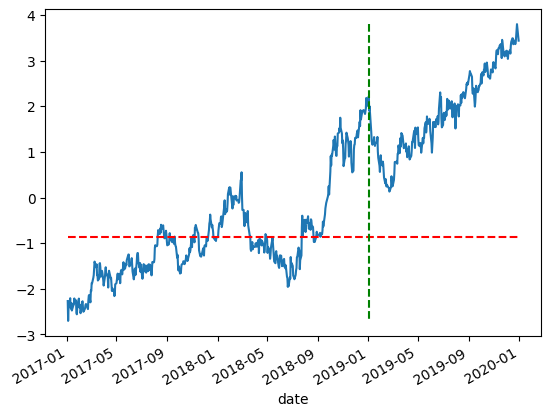

['MGC', 'FEX'] 0.2357128593045322 0.4622643562830026
[ 0.6311134  -1.06169963]


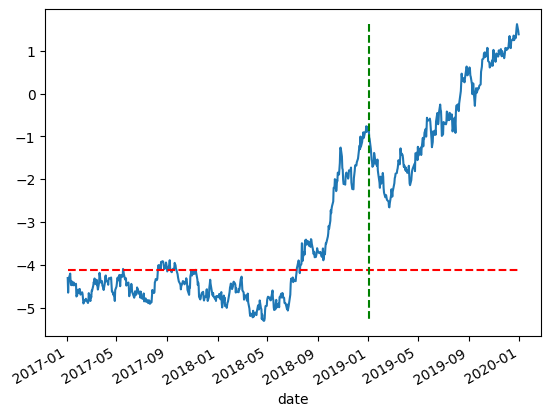

['MGC', 'ITOT'] 0.1820246311528259 0.550919503661834
[ 2.06232131 -3.20847634]


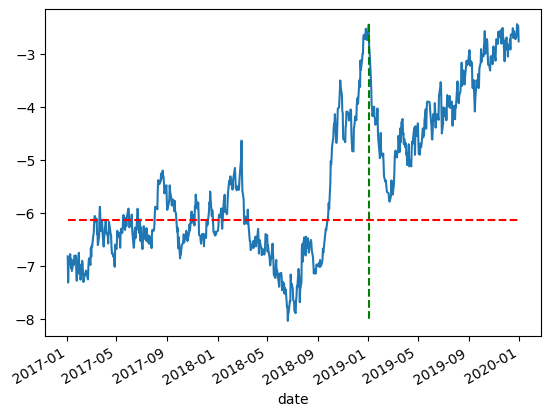

['MGC', 'VTI'] 0.1794010480594645 0.4883527137465477
[ 2.11651398 -1.46469557]


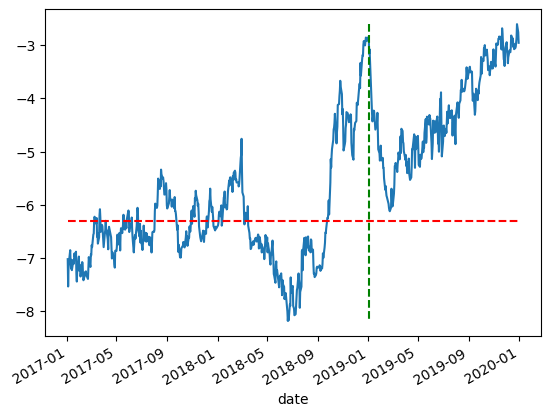

['VONE', 'RSP'] 0.371715484838267 0.8039511903374903
[ 1.02882484 -1.51961192]


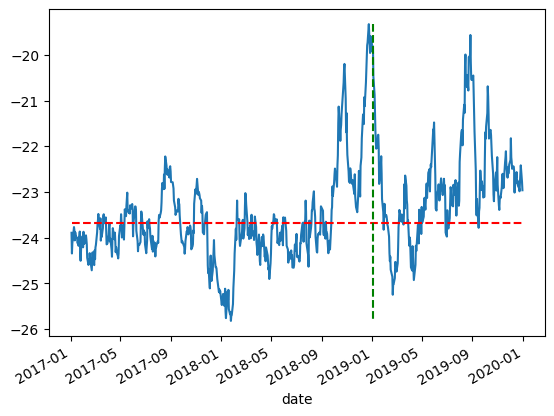

['VONE', 'IWB'] 0.3420603005045795 0.4101635336731334
[ 18.06694142 -14.79076777]


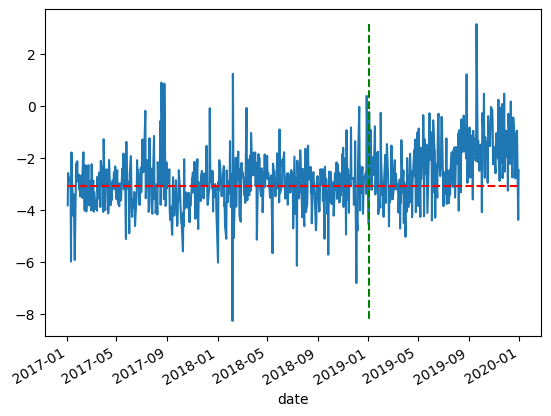

['VOO', 'RSP'] 0.3437968505331726 0.8083080264800606
[ 0.44761917 -1.3372626 ]


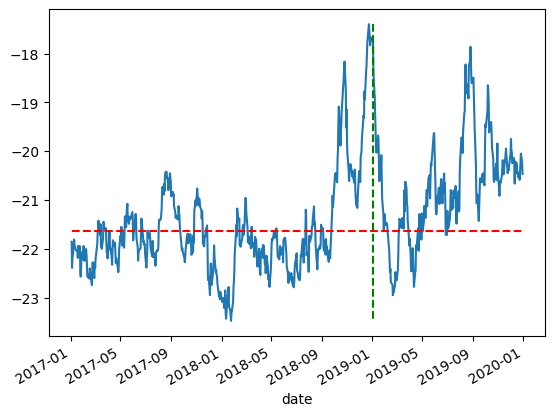

['VOO', 'SPY'] 0.5559462399528191 0.2853661601487082
[ 25.14041346 -23.39237421]


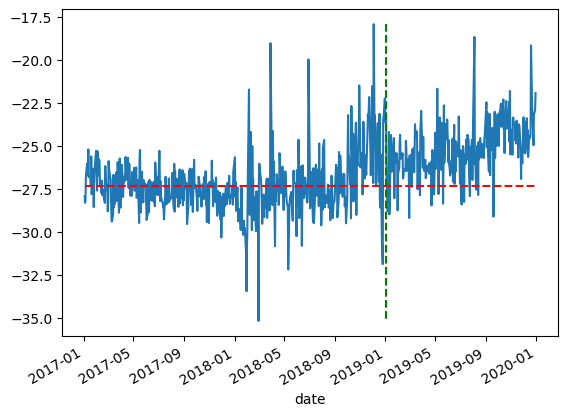

['VOO', 'IVV'] 0.1993551065915892 0.818890470812419
[ 29.31463762 -26.79936017]


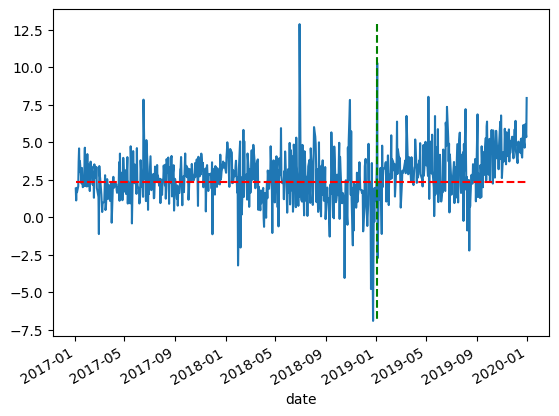

['RSP', 'SPY'] 0.3493355609036038 0.8103776354634848
[ 1.35119511 -0.42095629]


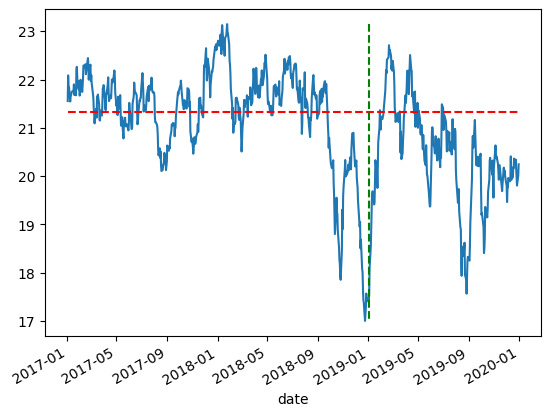

['RSP', 'VV'] 0.3350577058282274 0.82015270697404
[ 1.37687346 -0.91543698]


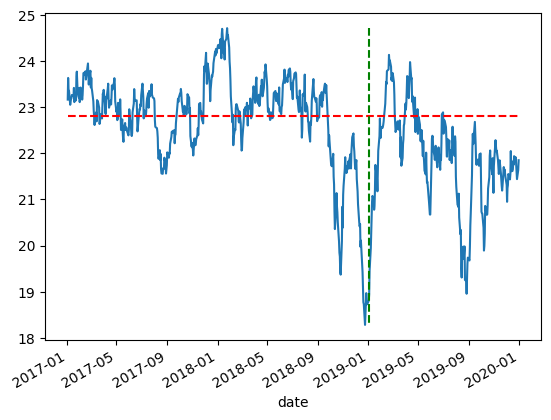

['RSP', 'IWV'] 0.4246208388242922 0.8553962128188773
[ 1.73708117 -0.90368156]


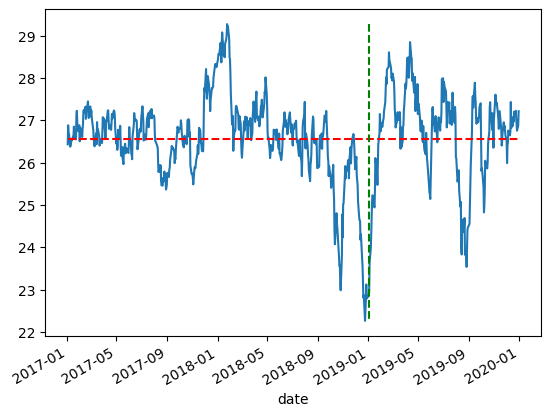

['RSP', 'IVV'] 0.3463336496939647 0.812966461566835
[ 1.33023984 -0.40713849]


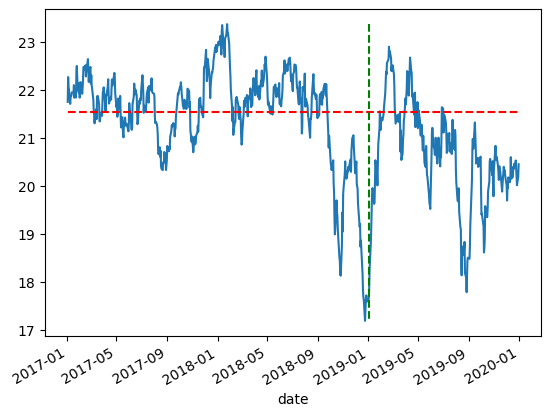

['RSP', 'ITOT'] 0.4220143924757146 0.859128299025347
[ 1.6834814 -2.2518333]


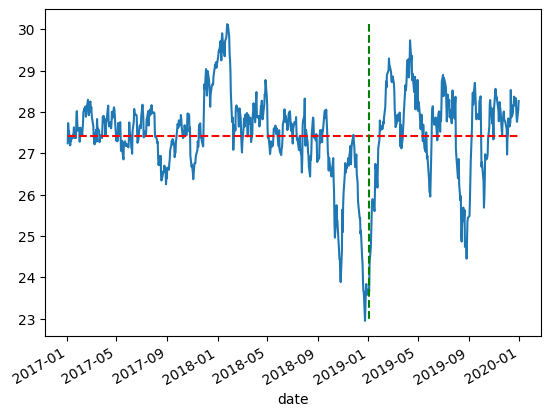

['RSP', 'IWB'] 0.3647165124419752 0.8168282200268575
[ 1.52775629 -0.84710344]


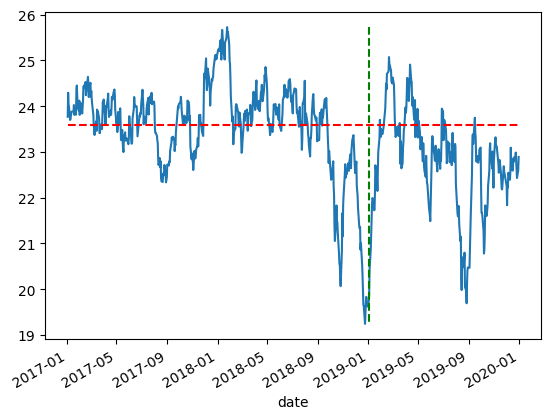

['RSP', 'VTI'] 0.418343095565413 0.8717450828314158
[ 1.64856982 -0.98062471]


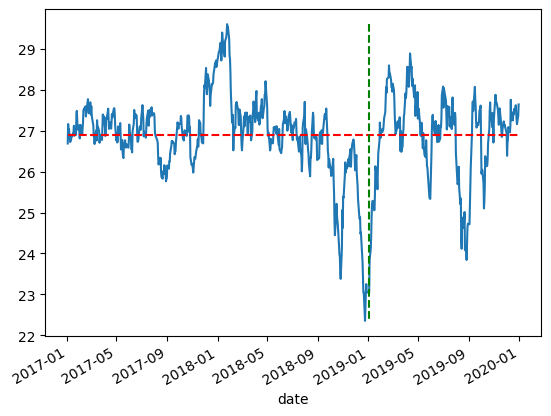

['RSP', 'SCHB'] 0.4130302859100592 0.8539788012938594
[ 1.67679622 -4.27153063]


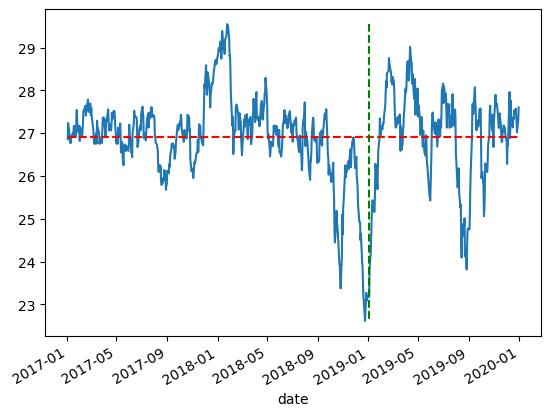

['SPY', 'IVV'] 0.3899285057204347 0.6126232623466508
[ 19.32512161 -18.99007451]


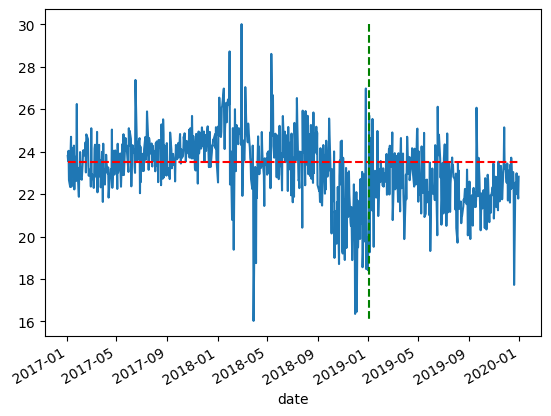

['IWV', 'SCHB'] 0.2964936861623689 0.8796740926200924
[ 18.5192215  -90.78727098]


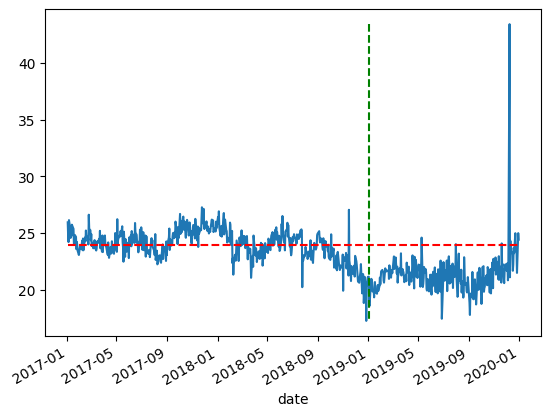

['ITOT', 'SCHB'] 0.7112382729309915 0.950085294424766
[  58.2817523  -111.08856752]


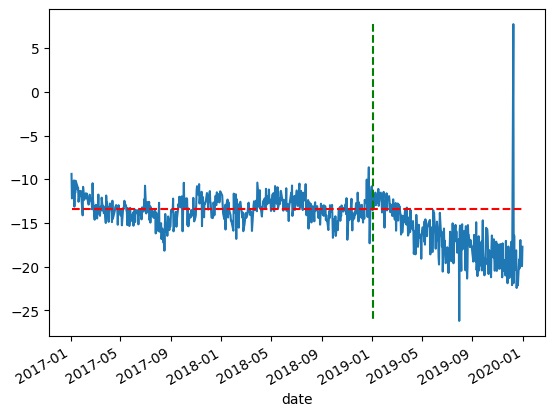

['VONE', 'IWB'] 0.5699022334502258 0.5794148351996082
[ 31.30321552 -25.71177746]


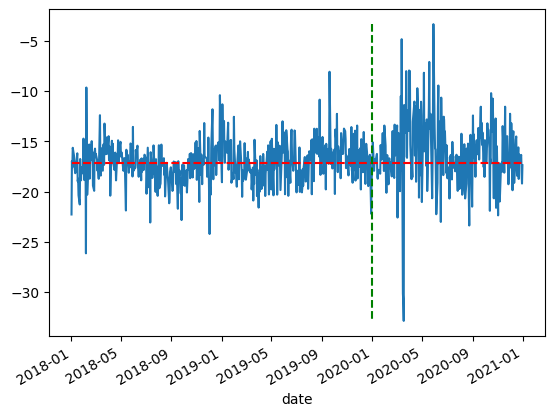

['VOO', 'SPY'] 0.5231312432916455 0.8020953409920643
[ 19.00296848 -17.73413566]


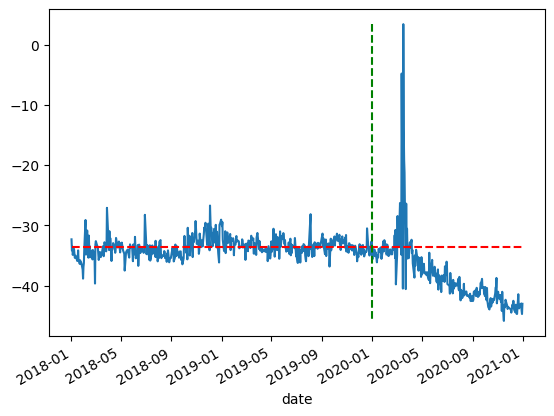

['VOO', 'IVV'] 0.6203736935582651 0.760224305196153
[ 25.9858182  -23.79612255]


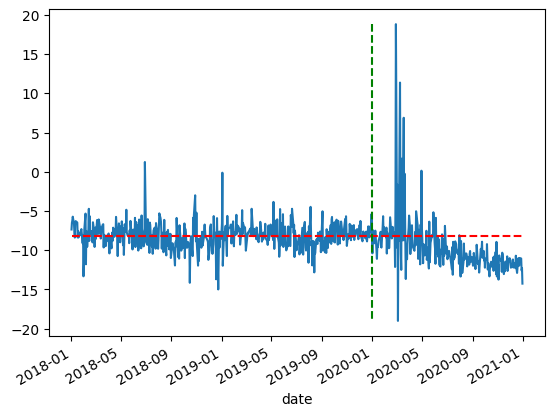

['SPY', 'IVV'] 0.5297093226128345 0.8138940871838143
[ 16.80844218 -16.49279381]


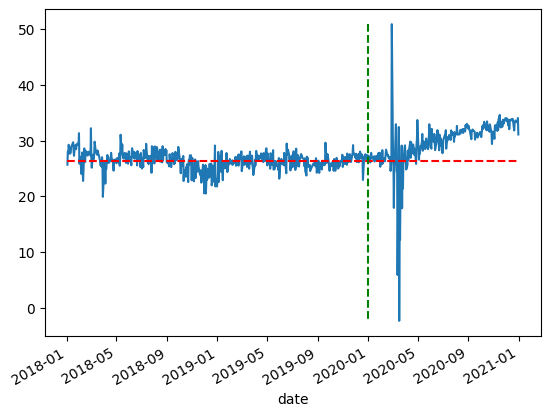

['ITOT', 'SCHB'] 0.6557205085404314 0.8087763607659288
[ 44.00380543 -83.03464667]


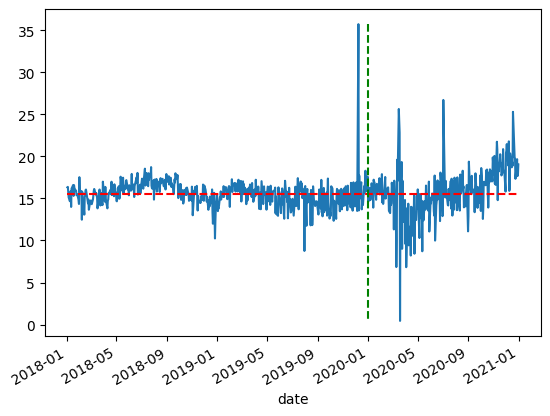

['VONE', 'IWB'] 0.654240348246204 0.5845825644750622
[ 23.18768667 -19.04064856]


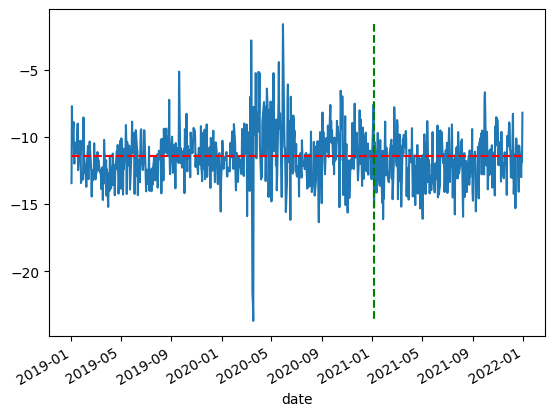

['VOO', 'IVV'] 0.476593222352103 0.5832962788065972
[ 24.49208859 -22.38877265]


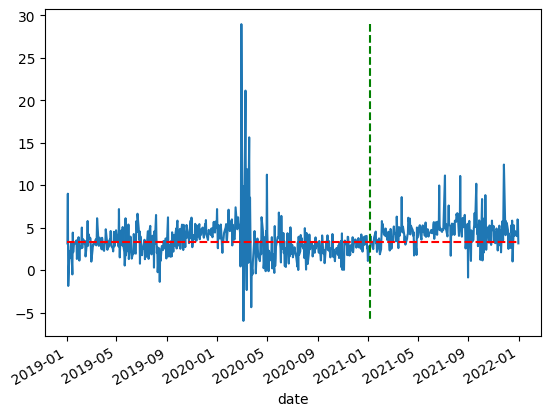

['VONE', 'IWB'] 0.4793708964357531 0.8135344242069995
[ 24.07082178 -19.75402982]


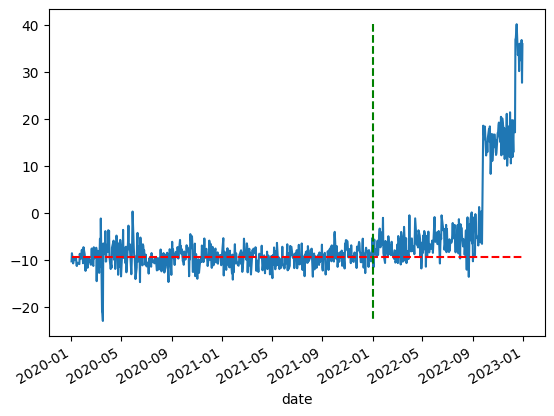

['VOO', 'SPY'] 0.6547152594400552 0.9837888668966346
[ 9.57038114 -8.8920153 ]


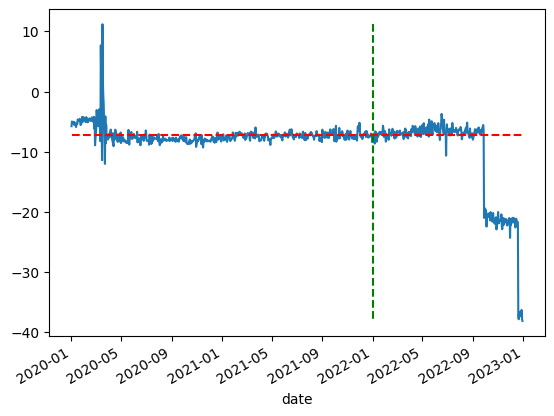

['VOO', 'IVV'] 1.0011764206524994e-06 3.599359199073365e-09
[ 23.15471342 -21.17732412]


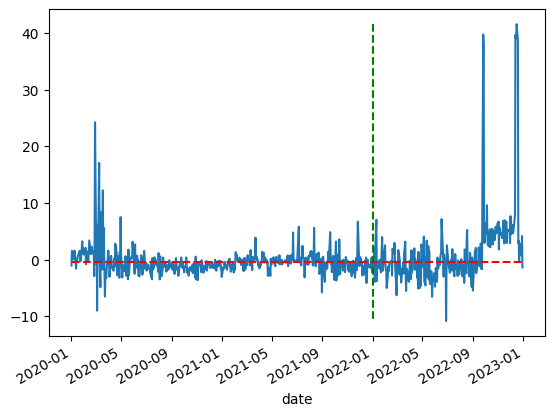

['SPY', 'IVV'] 0.7320710473692715 0.9489406277281018
[ 11.53142335 -11.35193676]


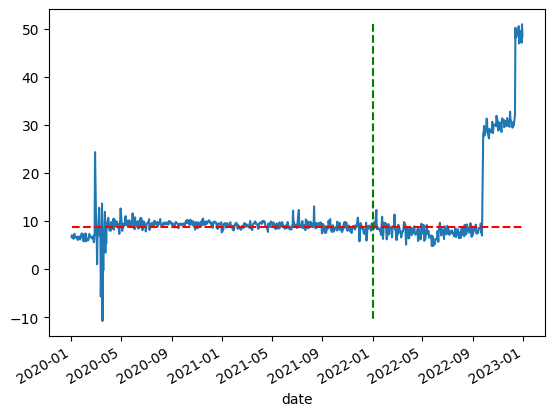

In [100]:
for _, pair_info in working.iterrows():
    pair = list(eval(pair_info['pair']))
    print(pair, pair_info['in_adf_n'], pair_info['out_adf_n'])

    price_in, price_out, ret_in, ret_out = yearly_sample(pair_info['year'], data)
    train, test = price_in[pair], price_out[pair]

    common_trend_vecm(train, test, adf = False)

In [73]:
pair = ('IWV', 'ITOT')

In [74]:
vecm_res[vecm_res.pair == str(pair)]

pair  stat1_ret  stat2_ret  stat1_price  stat2_price  \
65   ('IWV', 'ITOT')       1.00        1.0         1.00          1.0   
156  ('IWV', 'ITOT')       1.00        1.0         1.00          1.0   
247  ('IWV', 'ITOT')       1.00        1.0         1.00          1.0   
338  ('IWV', 'ITOT')       1.00        0.1         1.00          0.1   
429  ('IWV', 'ITOT')       1.00        1.0         1.00          1.0   
520  ('IWV', 'ITOT')       0.05        1.0         0.05          1.0   
611  ('IWV', 'ITOT')       0.10        0.1         0.05          0.1   
702  ('IWV', 'ITOT')       1.00        1.0         1.00          1.0   
793  ('IWV', 'ITOT')       0.01        1.0         0.05          1.0   
884  ('IWV', 'ITOT')       0.10        1.0         1.00          1.0   

     in_adf_n  in_adf_c  out_adf_n  out_adf_c  order  year  
65   0.539925  0.256666   0.983865   0.803986      5  2013  
156  0.595479  0.163449   0.850376   0.738244      5  2014  
247  0.808611  0.312844   0.574632   0.666014      4  2015  
338  0.848428  0.285824   0.916092   0.820207      1  2016  
429  0.823385  0.355152   0.999932   0.956092      2  2017  
520  0.577265  0.018807   0.133049   0.342503      5  2018  
611  0.489227  0.087686   0.975412   0.505506      8  2019  
702  0.090267  0.074824   0.048673   0.345323     10  2020  
793  0.607404  0.011609   0.234085   0.032494      9  2021  
884  0.542529  0.020738   0.815374   0.019908      9  2022

In [82]:
df = data[list(pair)].loc['2015']

In [83]:
df

IWV       ITOT
date                             
2015-01-02  107.816657  41.201651
2015-01-05  105.981329  40.463790
2015-01-06  104.851897  40.094859
2015-01-07  106.184274  40.547239
2015-01-08  108.081367  41.285100
...                ...        ...
2015-12-24  109.230342  41.801232
2015-12-28  108.978617  41.680870
2015-12-29  110.114334  42.106162
2015-12-30  109.286407  41.811682
2015-12-31  108.269496  41.432428

[252 rows x 2 columns]

In [510]:
ord = max(select_order(test_ret, 10).selected_orders.values())
j_res = get_johansen(test_ret, ord, mode = 0)
a, b = j_res.trace_stat, j_res.trace_stat_crit_vals

j_test = pd.DataFrame(b, columns = ['10%', '5%', '1%'], index = ['r=0', 'r<=1'])
j_test['test'] = a
# j_test.to_latex(f'./writeups/{test_pair[0].lower()}_{test_pair[1].lower()}_johansen.tex')
j_test

10%       5%       1%       test
r=0   13.4294  15.4943  19.9349  15.078611
r<=1   2.7055   3.8415   6.6349   4.917945

In [511]:
ord = max(select_order(oos_ret, 10).selected_orders.values())
j_res = get_johansen(oos_ret, ord, mode = 0)
a, b = j_res.trace_stat, j_res.trace_stat_crit_vals

j_test = pd.DataFrame(b, columns = ['10%', '5%', '1%'], index = ['r=0', 'r<=1'])
j_test['test'] = a
# j_test.to_latex(f'./writeups/{test_pair[0].lower()}_{test_pair[1].lower()}_out_johansen.tex')
j_test

10%       5%       1%       test
r=0   13.4294  15.4943  19.9349  21.217468
r<=1   2.7055   3.8415   6.6349   0.908088

In [485]:
seo = [9.391, 8.239, 8.4667, 8.8685, 9.1096, 30]
seo = pd.DataFrame(seo, columns = ['Seo Test'], index = ['sup-Wald', '10%', '5%', '2.5%', '1%', 'nboot']).T
seo.to_latex("./writeups/iwv_itot_seo_test.tex")

In [513]:
hseo = [29.64, 14.91, 15.31, 17.23, 0.00586, 100]
hseo = pd.DataFrame(hseo, columns = ['H-Seo Test'], index = ['Test Statistics', '10%', '5%', '1%', 'threshold', 'nboot']).T
hseo.to_latex("./writeups/spy_vv_hseo_test.tex")

[1, -1.0159263566131067]
(-6.515243234404821, 1.0754069487507229e-08, 5, 497, {'1%': -3.4435761493506294, '5%': -2.867372960189225, '10%': -2.5698767442886696}, -1686.1303116963536)
True


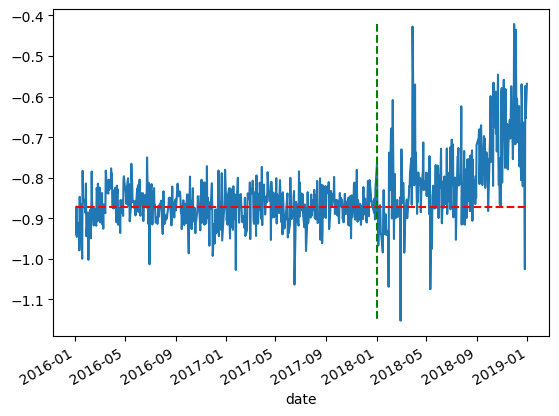

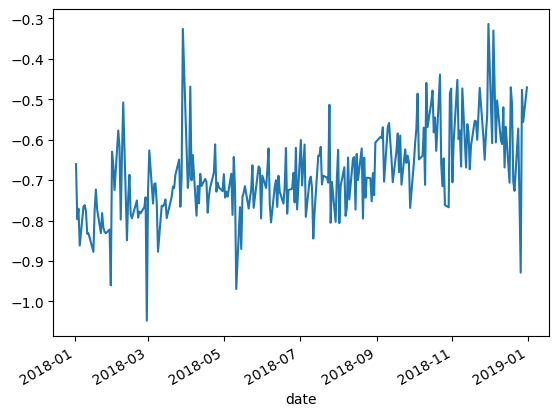

[ 1.         -1.01166234]
(-0.838088416981259, 0.807677127030318, 12, 490, {'1%': -3.4437660979098843, '5%': -2.8674565460819896, '10%': -2.569921291128696}, -1660.1099595229616)


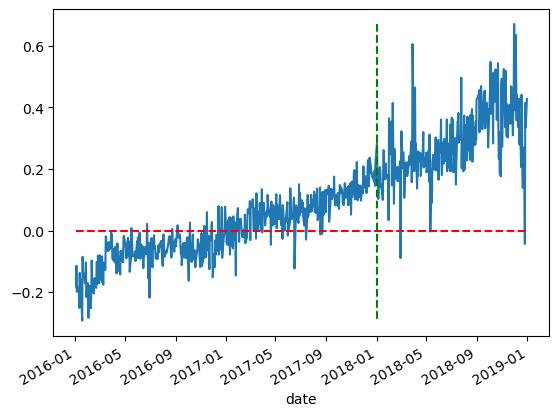

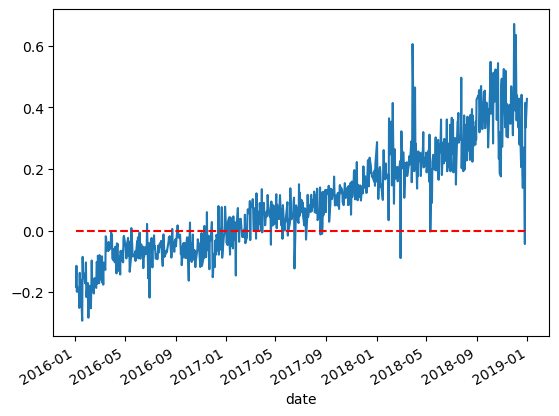

In [501]:
sp = common_trend_ols(test_price, oos_price)
plt.show()
spv = common_trend_vecm(test_price, test_price, oos_price, oos_price)

## Kernel Estimation

In [71]:
spy = price_in['SPY'].pct_change().dropna()
in_sample = ret_in[['IVV','VOO']].iloc[1:]
out_spy = price_out['SPY'].pct_change().dropna()

In [291]:
in_sample = ret_in[['RSP','IWV']].iloc[1:]

In [421]:
import statsmodels.nonparametric.bandwidths as bw
import statsmodels.api as sm

def normal_pdf(x, scale = 2.5, const = 1):
    return np.exp(-0.5 * (x*scale)**2) / const

def gaussian_kernel(x, ker_x):
    h = bw.bw_scott(ker_x)
    kernel_val = normal_pdf((x - ker_x)/h) / h
    return kernel_val

def kernel_regresssion(z, x_train, y_train, z_train):
    z = np.asarray(z)
    num_prep = x_train * y_train
    den_prep = x_train **2
    def kernel(z):
        w = gaussian_kernel(z, z_train)
        return np.sum(num_prep * w) / np.sum(den_prep * w)
    kernel = np.vectorize(kernel)
    return kernel(z)

def get_max_chi_pval(p, k, m, nboot = int(1e4)):
    chi_cval = np.zeros(nboot)
    for i in range(nboot):
        chi_cval[i] = np.random.chisquare(k, m).max()
    return (chi_cval > p).mean()


u_range = np.arange(-1, 1, 1e-5)
def stability_test(x_train, y_train, z_train):
    beta_const = sm.OLS(y_train, x_train).fit().params[0]
    betas = kernel_regresssion(z_train, x_train, y_train, z_train)
    u = y_train - betas * x_train
    n = len(x_train)
    h = bw.bw_scott(z_train)
    
    sig_u = u.var()
    xt_2 = x_train **2
    deno_prep = np.vectorize(lambda z: 1/n**2 * np.sum(gaussian_kernel(z, z_train) * xt_2))
    deno = deno_prep(z_train)
    nu0 = np.sum(normal_pdf(u_range) ** 2) * 1e-5
    omega = sig_u * nu0/deno
    
    T = n**2 * np.sqrt(h) * (betas - beta_const) / np.sqrt(omega) # Is m * 1 vector where m = len(z_train)
    Tm = abs(T).max()
    pval = get_max_chi_pval(Tm, 1, n)
    return Tm, pval


def coint_test(x_train, y_train, z_train):
    beta_const = sm.OLS(y_train, x_train).fit().params[0]
    betas = kernel_regresssion(z_train, x_train, y_train, z_train)
    u = y_train - betas * x_train
    n = len(u)
    time = np.arange(n)
    mod = sm.OLS(u**2, sm.add_constant(time)).fit()
    b_hat = mod.params[1]
    u2_mean = (u**2).mean()
    
    M = int(np.sqrt(n))
    khM_ch = lambda h: np.sum((u.iloc[:-h] - u2_mean) * (u.iloc[h:]**2 - u2_mean))/n
    omega_val = np.vectorize(khM_ch)
    M_range = np.arange(-M, M)
    omega2 = np.sum(omega_val(M_range))
    t_sum = time.var() * n
    s_b = np.sqrt(omega2/t_sum)
    return b_hat/s_b

In [420]:
pval = stability_test(in_sample.iloc[:,0], in_sample.iloc[:,1], spy)
pval

(1926.2885421761412, 0.0)

In [422]:
coint_test(in_sample.iloc[:,0], in_sample.iloc[:,1], spy)

-0.07222983131174325

In [410]:
np.sum(normal_pdf(u_range, scale = 2.5, const =1)) * 1e-5

0.9901990517066612

In [409]:
normal_pdf(0, scale = 2.5, const = 1)

1.0

In [406]:
from scipy.optimize import minimize

In [417]:
def test(z):
    x, y= z[0], z[1]
    return 2 - normal_pdf(0, scale = x, const = y) - np.sum(normal_pdf(u_range)) * 1e-5

In [294]:
beta = kernel_regresssion(spy, in_sample.iloc[:,0], in_sample.iloc[:,1], spy)
beta

array([0.96119512, 0.96571633, 0.95379373, 0.96026454, 0.95921012,
       0.955052  , 0.97620363, 0.96817071, 0.95320917, 0.96376121,
       0.96509715, 0.95473747, 0.95921552, 0.96749036, 0.99396189,
       0.96444058, 0.95358178, 0.9687852 , 0.96785453, 0.96421659,
       0.99745134, 0.95544312, 0.9636703 , 0.96846284, 0.96802626,
       0.95659628, 0.96820381, 0.95959274, 0.95315917, 0.95326142,
       0.95795166, 0.96498167, 0.95352946, 0.9634368 , 0.95327517,
       0.96171182, 0.96066438, 0.95317174, 0.95535332, 0.96564216,
       0.97116989, 0.95861382, 0.95575371, 0.95976085, 0.96207347,
       0.96442213, 0.96014507, 0.97010782, 0.96568588, 0.96322378,
       0.95580263, 0.96419749, 0.95347419, 0.9654266 , 0.96518805,
       0.95319291, 0.96591838, 0.96509856, 0.95315929, 0.95957132,
       0.95458643, 0.95422123, 0.9638085 , 0.97120616, 0.96990619,
       0.95349649, 0.96803751, 0.99396732, 0.9683433 , 0.95829498,
       0.95515055, 0.96766903, 0.95750765, 0.95406398, 0.95326

<AxesSubplot: >

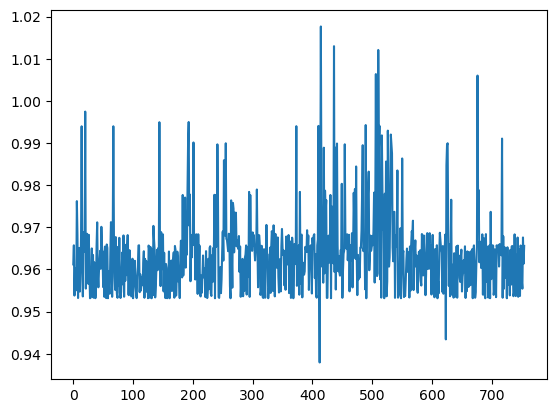

In [295]:
pd.Series(beta).plot()